In [25]:
from ChargeAPI.API_infrastructure.charge_request import module_version
from rdkit.Chem import rdmolfiles
import rdkit
from rdkit import Chem
import json
from rdkit.Chem import Draw, rdMolAlign


In [11]:
supplier = Chem.SDMolSupplier("./optimised_molecules.sdf",removeHs=False)


In [19]:
images = []
for i, mol in enumerate(supplier):
    mol_block = rdmolfiles.MolToMolBlock(mol)
    charge_result = module_version.handle_charge_request(conformer_mol=mol_block,
                                                         charge_model='MBIS_WB_GAS_CHARGE_DIPOLE')
    charges = json.loads(charge_result['charge_result'])
    for i, atom in enumerate(mol.GetAtoms()):
        lbl = '%.3f' % (charges[i])
        atom.SetProp('atomNote', lbl)
    images.append(mol)
img = Draw.MolsToGridImage(images, subImgSize=(400, 400), returnPNG=False)


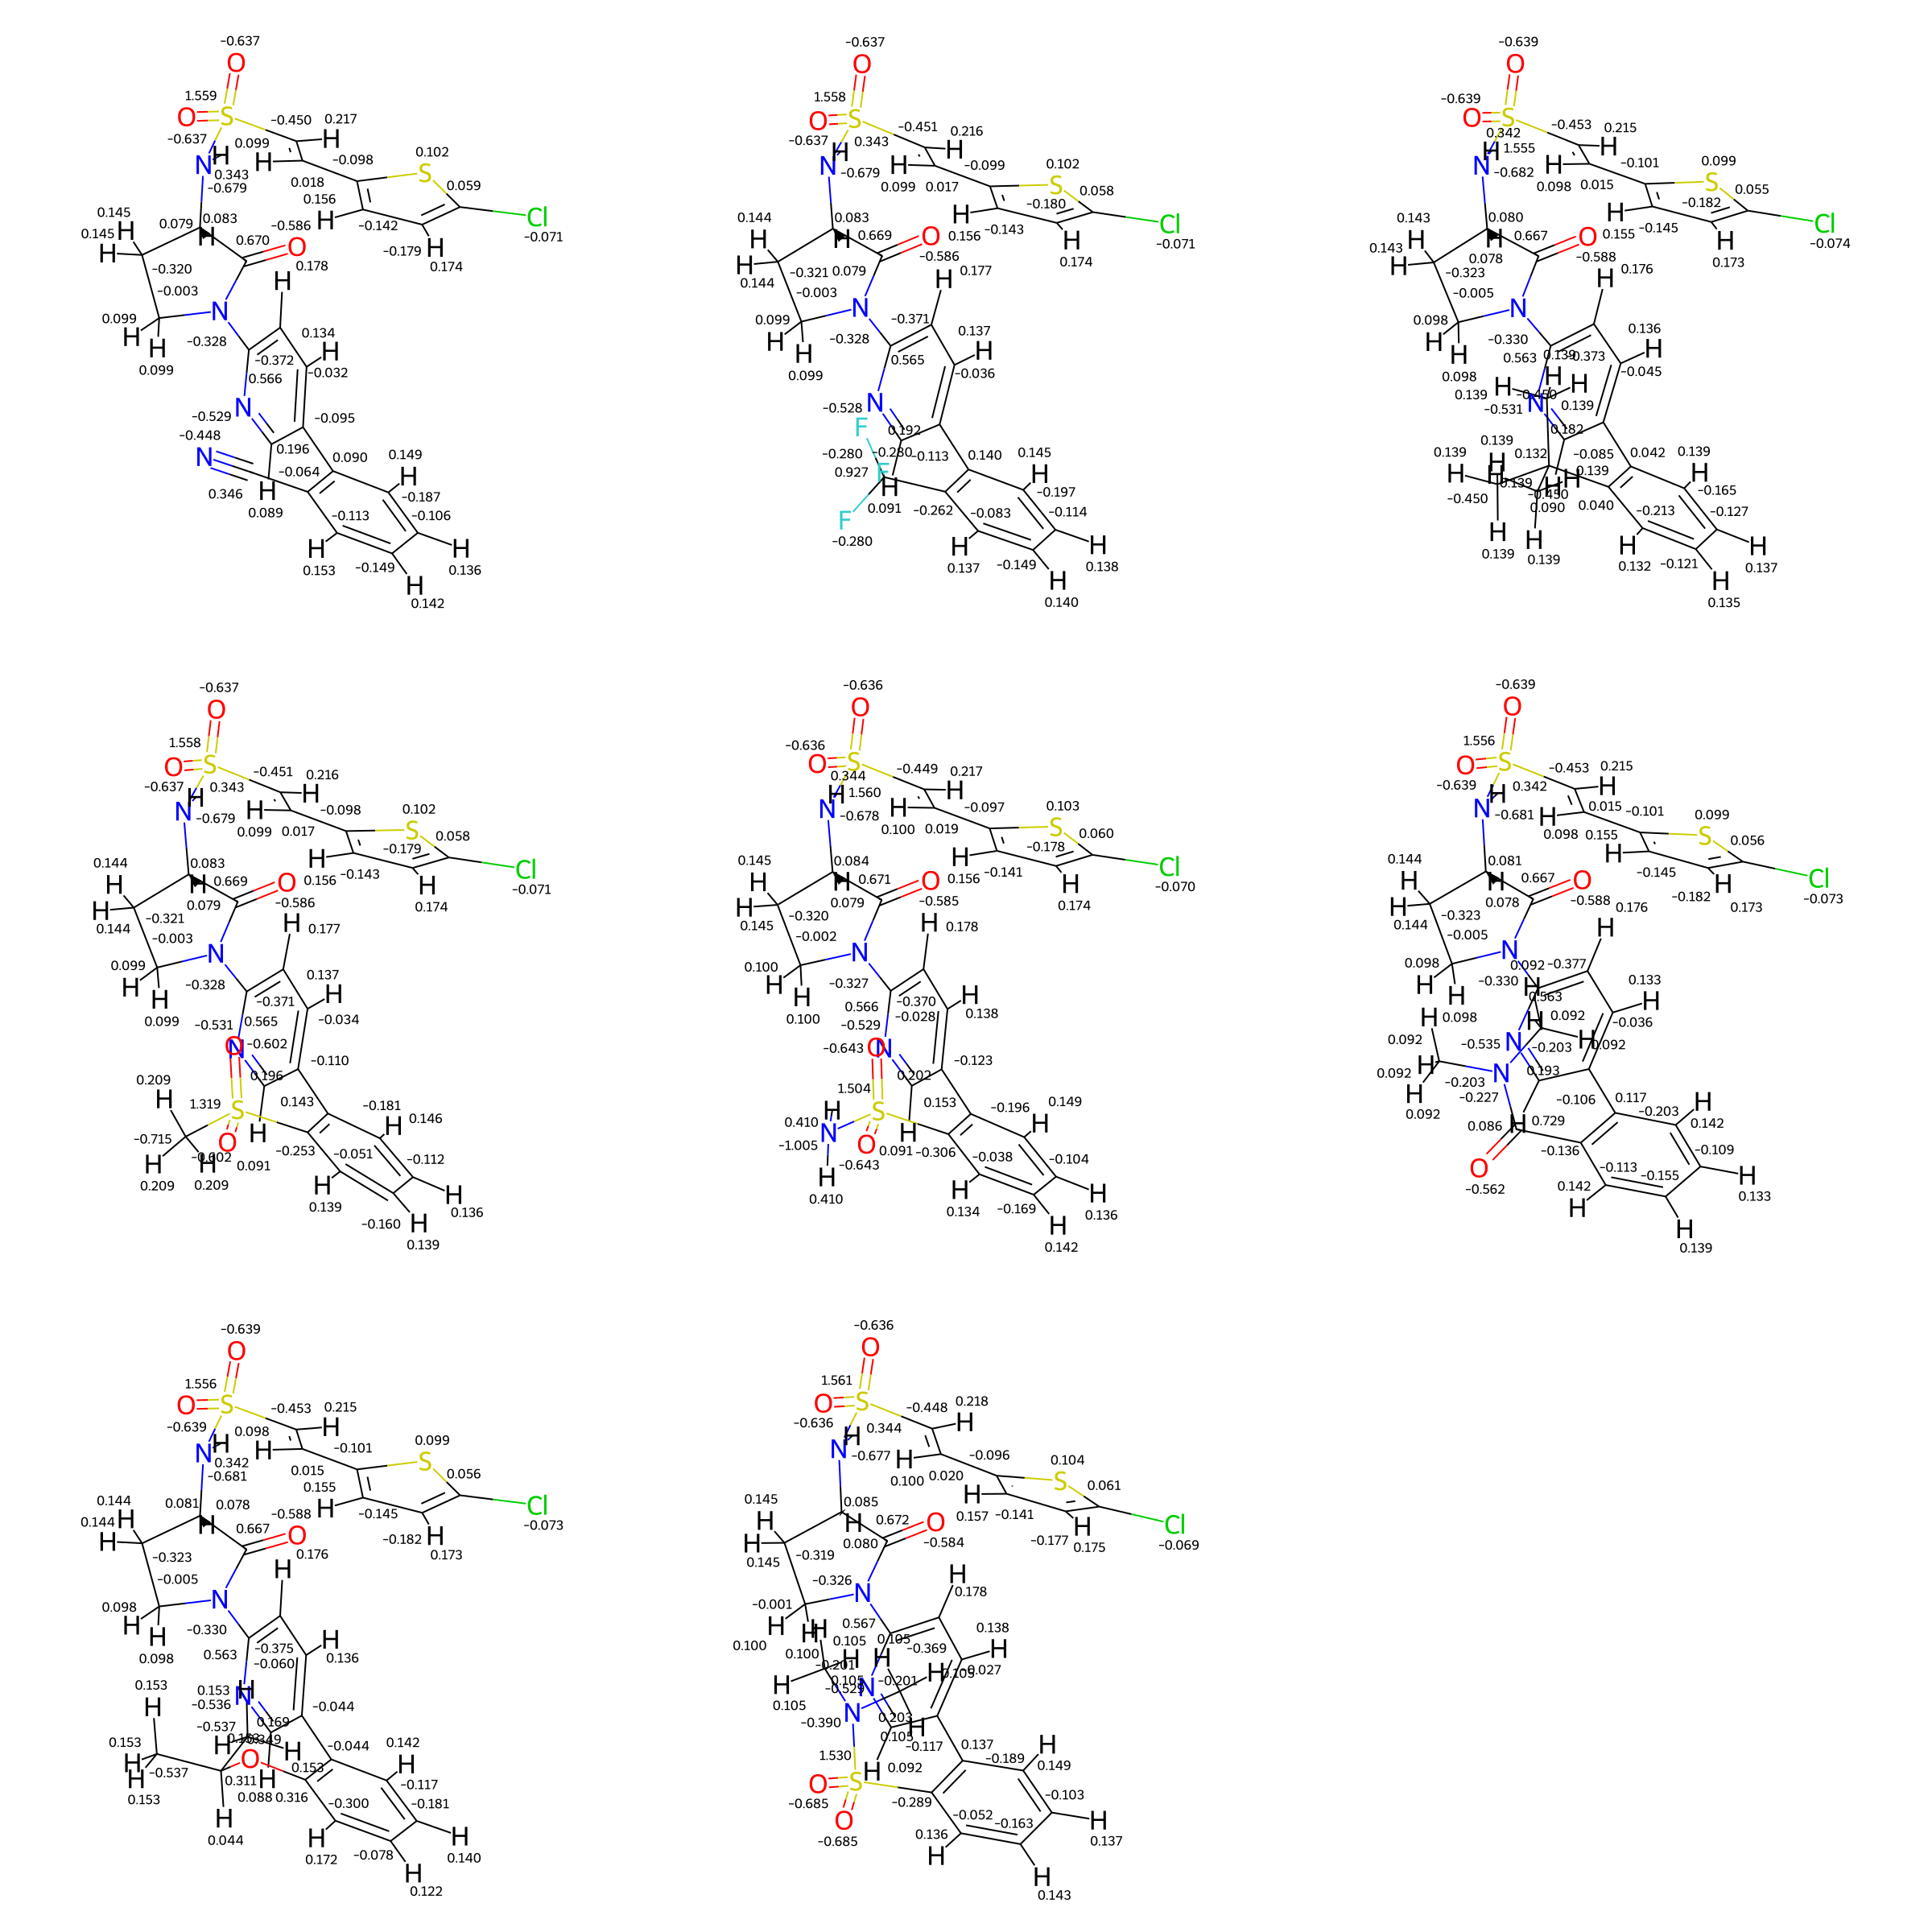

In [22]:
img = Draw.MolsToGridImage(images, subImgSize=(800, 800), returnPNG=False)
img

In [28]:
from rdkit import Chem
from rdkit.Chem import rdFMCS, rdMolAlign, Draw
import json

supplier = Chem.SDMolSupplier("./Tim_combined.sdf", removeHs=False)

images = []
last_mol = None

for i, mol in enumerate(supplier):
    if mol is None:
        continue

    # Remove hydrogens for consistency
    mol = Chem.RemoveHs(mol)

    if last_mol is not None:
        last_mol = Chem.RemoveHs(last_mol)

        # Find the Maximum Common Substructure (MCS)
        mcs = rdFMCS.FindMCS([last_mol, mol])
        mcs_smarts = mcs.smartsString
        mcs_mol = Chem.MolFromSmarts(mcs_smarts)

        # Get the atom indices for the MCS in each molecule
        ref_match = last_mol.GetSubstructMatch(mcs_mol)
        probe_match = mol.GetSubstructMatch(mcs_mol)

        if not ref_match or not probe_match:
            print("No common substructure found between the molecules. Skipping alignment.")
        else:
            # Align using the atom mapping
            atom_map = list(zip(probe_match, ref_match))
            rdMolAlign.AlignMol(mol, last_mol, atomMap=atom_map)

    # Compute partial charges (replace with your actual function)
    mol_block = Chem.MolToMolBlock(mol)
    charge_result = module_version.handle_charge_request(
        conformer_mol=mol_block,
        charge_model='MBIS_WB_GAS_CHARGE_DIPOLE'
    )
    charges = json.loads(charge_result['charge_result'])
    for idx, atom in enumerate(mol.GetAtoms()):
        lbl = '%.3f' % (charges[idx])
        atom.SetProp('atomNote', lbl)

    images.append(mol)
    last_mol = mol

# Generate the image grid
img = Draw.MolsToGridImage(images, subImgSize=(400, 400), returnPNG=False)
img.show()


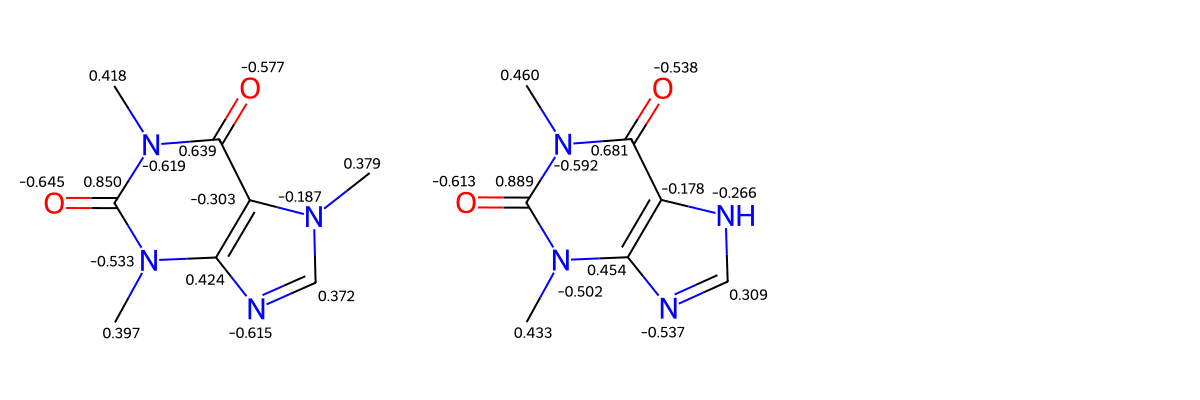

In [29]:
img